<a href="https://colab.research.google.com/github/bhanup6663/GAN_pratice/blob/main/WGAN-GP_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
batch_size = 256
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


100%|██████████| 26421880/26421880 [00:02<00:00, 8980283.65it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 170587.80it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3186606.53it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20862103.37it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [40]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 7*7*256),
            nn.BatchNorm1d(7*7*256),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, 5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 1, 5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [42]:
# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(7*7*128, 1)
        )

    def forward(self, x):
        return self.model(x)

In [43]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [44]:
# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.9))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.9))


In [45]:
# Loss function and gradient penalty
def gradient_penalty(real, fake, discriminator):
    alpha = torch.rand(real.size(0), 1, 1, 1, device=device)
    interpolated = (alpha * real.data + (1 - alpha) * fake.data).requires_grad_(True)
    d_interpolated = discriminator(interpolated)
    gradients = torch.autograd.grad(outputs=d_interpolated, inputs=interpolated,
                                    grad_outputs=torch.ones(d_interpolated.size()).to(device),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [46]:
# Training function
def train(generator, discriminator, data_loader, epochs):
    generator.train()
    discriminator.train()
    d_losses, g_losses = [], []

    for epoch in range(epochs):
        for i, (imgs, _) in enumerate(data_loader):
            imgs = imgs.to(device)

            # Training discriminator
            for _ in range(3):
                noise = torch.randn(imgs.size(0), 100, device=device)
                fake_imgs = generator(noise)
                real_preds = discriminator(imgs)
                fake_preds = discriminator(fake_imgs.detach())
                gp = gradient_penalty(imgs, fake_imgs, discriminator)
                d_loss = fake_preds.mean() - real_preds.mean() + 10 * gp
                d_optimizer.zero_grad()
                d_loss.backward()
                d_optimizer.step()

            # Training generator
            noise = torch.randn(imgs.size(0), 100, device=device)
            fake_imgs = generator(noise)
            fake_preds = discriminator(fake_imgs)
            g_loss = -fake_preds.mean()
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            if (i+1) % 100 == 0:
                d_losses.append(d_loss.item())
                g_losses.append(g_loss.item())
                print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(data_loader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.title("Training Losses")
    plt.legend()
    plt.show()

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/30], Step [100/235], D Loss: -6.9150, G Loss: 13.1359
Epoch [1/30], Step [200/235], D Loss: -3.3678, G Loss: 6.7714
Epoch [2/30], Step [100/235], D Loss: -2.4780, G Loss: 2.6627
Epoch [2/30], Step [200/235], D Loss: -2.5001, G Loss: 0.1995
Epoch [3/30], Step [100/235], D Loss: -2.1945, G Loss: -3.7256
Epoch [3/30], Step [200/235], D Loss: -2.2832, G Loss: -3.7412
Epoch [4/30], Step [100/235], D Loss: -1.6257, G Loss: -3.1634
Epoch [4/30], Step [200/235], D Loss: -2.5920, G Loss: -2.5127
Epoch [5/30], Step [100/235], D Loss: -1.0815, G Loss: -2.0294
Epoch [5/30], Step [200/235], D Loss: -1.3497, G Loss: -2.0120
Epoch [6/30], Step [100/235], D Loss: -1.2200, G Loss: -0.1536
Epoch [6/30], Step [200/235], D Loss: -0.8559, G Loss: -1.7711
Epoch [7/30], Step [100/235], D Loss: -0.7810, G Loss: -1.9522
Epoch [7/30], Step [200/235], D Loss: -1.3290, G Loss: 2.4113
Epoch [8/30], Step [100/235], D Loss: -1.3021, G Loss: -0.7480
Epoch [8/30], Step [200/235], D Loss: -1.1873, G Loss: 0.42

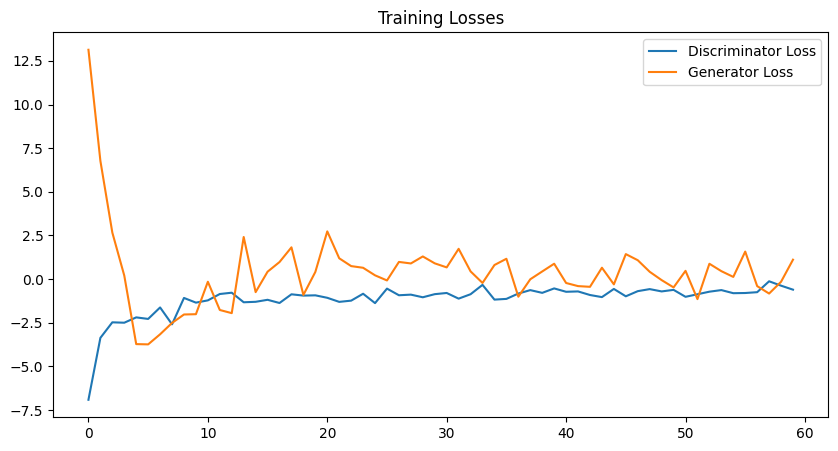

In [47]:
train(generator, discriminator, train_loader, 30)

In [48]:
# Save the generator model
torch.save(generator.state_dict(), 'generator_wgan_gp.pth')

In [49]:
# Assuming the generator class is already defined as Generator

# Initialize a new generator instance
generator = Generator().to(device)

# Load the model parameters
generator.load_state_dict(torch.load('generator_wgan_gp.pth', map_location=device))

# If you saved the entire model
# generator = torch.load('generator_wgan_gp_full.pth', map_location=device)

generator.eval()  # Set the generator to evaluation mode


Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=12544, bias=True)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Unflatten(dim=1, unflattened_size=(256, 7, 7))
    (4): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2)
    (10): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (11): Tanh()
  )
)

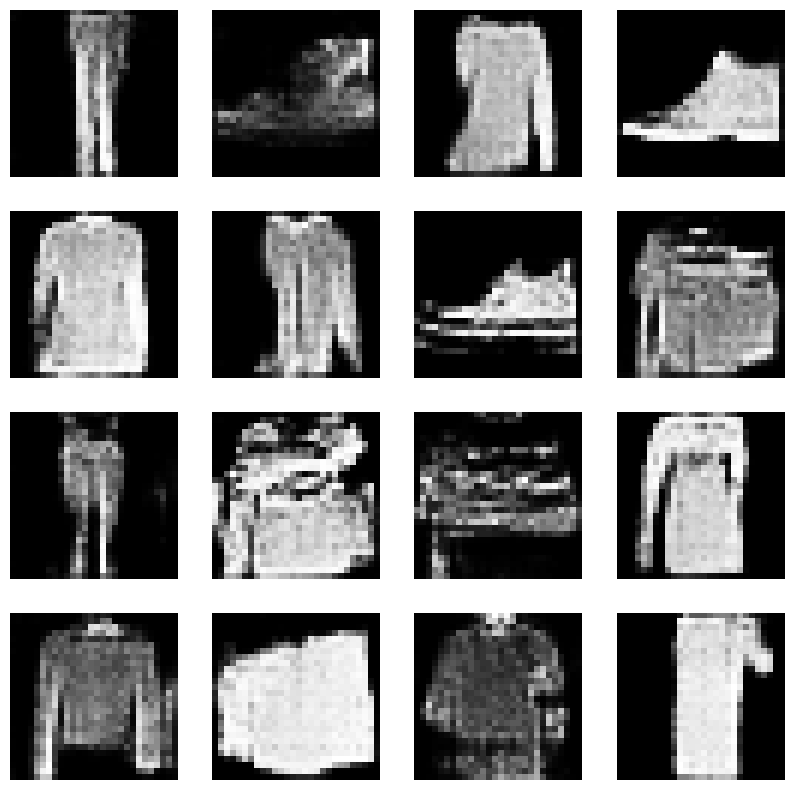

In [50]:
# Create random noise vectors
num_images_to_generate = 16
noise = torch.randn(num_images_to_generate, 100, device=device)

# Generate images
with torch.no_grad():  # We don't need to track gradients here
    generated_images = generator(noise).cpu().numpy()

# Post-processing and visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for ax, img in zip(axes.flatten(), generated_images):
    ax.imshow(img.squeeze(), cmap='gray')  # Assuming the image is grayscale
    ax.axis('off')
plt.show()
